In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense , Dropout
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
import warnings

warnings.filterwarnings('ignore')

In [ ]:
def load_and_prep(filename):
    # Load

    df = pd.read_excel(filename)

    # Transform
    df_total = df[df['Country/Region'] == 'Total'].drop(columns=['Country/Region', 'Total'])
    df_long = df_total.melt(var_name='Date_Str', value_name='Value')
    df_long['Date'] = pd.to_datetime(df_long['Date_Str'], format='%b-%Y')
    df_long = df_long.sort_values('Date').set_index('Date')
    return df_long['Value']

In [3]:
def create_lstm_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back)])
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

In [ ]:
def train_lstm_model(train_data, look_back=3, epochs=50):
    # Scale
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))

    
    X_train, y_train = create_lstm_dataset(train_scaled, look_back)
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

    
    model = Sequential()
    model.add(LSTM(80, input_shape=(1, look_back), activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')

    
    es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=2, verbose=0, callbacks=[es])

    return model, scaler

In [ ]:
def forecast_lstm(model, scaler, train_data, steps, look_back=3):
    
    curr_seq = scaler.transform(train_data[-look_back:].reshape(-1, 1))
    forecast = []

    for _ in range(steps):
        input_seq = curr_seq.reshape(1, 1, look_back)
        pred = model.predict(input_seq, verbose=0)
        forecast.append(pred[0, 0])
        curr_seq = np.append(curr_seq[1:], pred).reshape(-1, 1)

    return scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()

In [ ]:
def run_comparison(name, filename, sarima_order, seasonal_order, use_log=False):
    print(f"\n--- Processing {name} Data ---")

    
    series = load_and_prep(filename)
    test_len = 12
    train = series.iloc[:-test_len]
    test = series.iloc[-test_len:]

    
    if use_log:
        train_model_input = np.log(train)
        test_model_target = np.log(test)
    else:
        train_model_input = train
        test_model_target = test

    # --------------------------------------
    # Model A: SARIMAX
    # --------------------------------------
    print("Running Model 1: SARIMAX...")
    model_s = SARIMAX(train_model_input, order=sarima_order, seasonal_order=seasonal_order,
                      enforce_stationarity=False, enforce_invertibility=False)
    fit_s = model_s.fit(disp=False)
    # fit_s
    pred_s = fit_s.forecast(steps=test_len)

    # --------------------------------------
    # Model B: Pure LSTM
    # --------------------------------------
    print("Running Model 2: Pure LSTM...")
    look_back = 4
    lstm_model, lstm_scaler = train_lstm_model(train_model_input.values, look_back=look_back)
    # lstm_model
    pred_l = forecast_lstm(lstm_model, lstm_scaler, train_model_input.values, test_len, look_back)
    pred_l = pd.Series(pred_l, index=test.index)

    # --------------------------------------
    # Model C: Hybrid (SARIMAX + LSTM Residuals)
    # --------------------------------------
    print("Running Model 3: Hybrid (SARIMAX + LSTM)...")
    # Get residuals from training
    train_resid = train_model_input - fit_s.fittedvalues
    # Train LSTM on Residuals
    hybrid_lstm, hybrid_scaler = train_lstm_model(train_resid.values, look_back=look_back)
    # hybrid_lstm
    # Forecast Residuals
    pred_resid = forecast_lstm(hybrid_lstm, hybrid_scaler, train_resid.values, test_len, look_back)
    # Add to SARIMAX Forecast
    pred_h = pred_s + pred_resid

    # --------------------------------------
    # Inverse Transform & Evaluation
    # --------------------------------------
    if use_log:
        final_s = np.exp(pred_s)
        final_l = np.exp(pred_l)
        final_h = np.exp(pred_h)
    else:
        final_s = pred_s
        final_l = pred_l
        final_h = pred_h

    rmse_s = np.sqrt(mean_squared_error(test, final_s))
    rmse_l = np.sqrt(mean_squared_error(test, final_l))
    rmse_h = np.sqrt(mean_squared_error(test, final_h))

    print(f"RESULTS ({name}):")
    print(f"  SARIMAX RMSE: {rmse_s:.4f}")
    print(f"  LSTM RMSE:    {rmse_l:.4f}")
    print(f"  Hybrid RMSE:  {rmse_h:.4f}")

    # --------------------------------------
    # Visualization
    # --------------------------------------
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, test, label='Actual Data', color='black', linewidth=2, marker='o')
    plt.plot(test.index, final_s, label=f'SARIMAX (RMSE: {rmse_s:.2f})', linestyle='--')
    plt.plot(test.index, final_l, label=f'LSTM (RMSE: {rmse_l:.2f})', linestyle='--')
    plt.plot(test.index, final_h, label=f'Hybrid (RMSE: {rmse_h:.2f})', linewidth=2)

    plt.title(f'Model Comparison: {name} Forecasting')
    plt.ylabel('Value (Million USD)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return rmse_s, rmse_l, rmse_h, fit_s, lstm_model, hybrid_lstm


--- Processing Graphite Import Data ---
Running Model 1: SARIMAX...
Running Model 2: Pure LSTM...
Running Model 3: Hybrid (SARIMAX + LSTM)...
RESULTS (Graphite Import):
  SARIMAX RMSE: 1.1258
  LSTM RMSE:    1.2161
  Hybrid RMSE:  1.2530


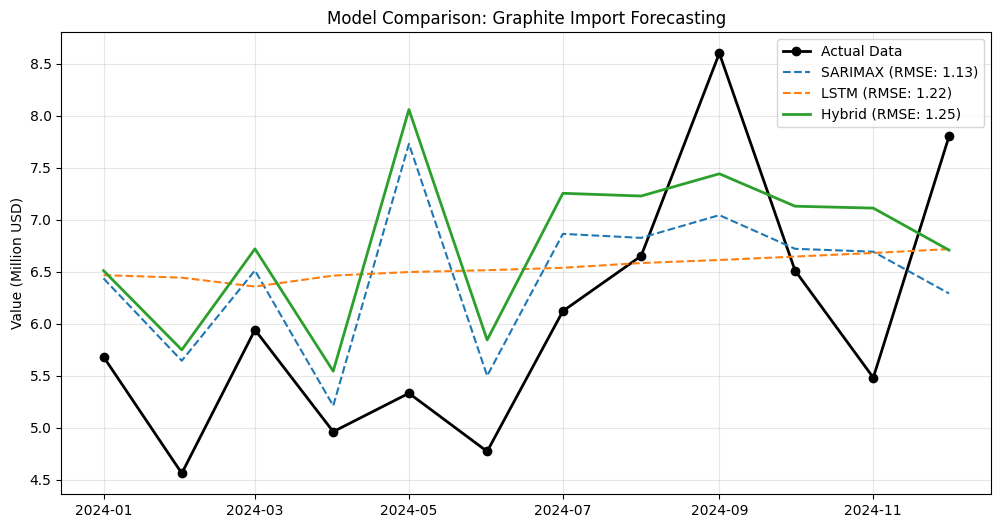

In [7]:
rmse_imp_s, rmse_imp_l, rmse_imp_h , sarimax_import , lstm_import , hybrid_import = run_comparison(
    name="Graphite Import",
    filename='Graphite import Forecsting.xlsx',
    sarima_order=(2, 0, 0),
    seasonal_order=(1, 1, 1, 12),
    use_log=False
)


--- Processing Graphite export Data ---
Running Model 1: SARIMAX...
Running Model 2: Pure LSTM...
Running Model 3: Hybrid (SARIMAX + LSTM)...
RESULTS (Graphite export):
  SARIMAX RMSE: 0.9221
  LSTM RMSE:    0.8952
  Hybrid RMSE:  0.9072


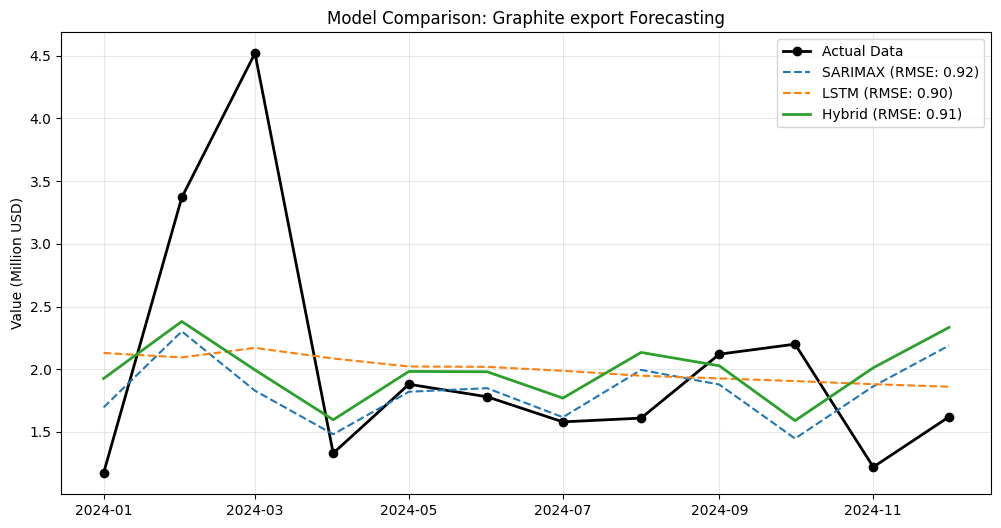

In [9]:
rmse_imp_s, rmse_imp_l, rmse_imp_h, sarimax_export , lstm_export , hybrid_export = run_comparison(
    name="Graphite export",
    filename='Graphite export Forecasting.xlsx',
    sarima_order=(3, 0, 1),
    seasonal_order=(1, 1, 1, 12),
    use_log=False
)

In [12]:
def load_country_data(filename):
    df = pd.read_excel(filename)
    # Get date columns for time-series analysis
    date_cols = [c for c in df.columns if c not in ['Country/Region', 'Total']]

    # Calculate Total Volume per Country
    # (Using the 'Total' column provided in file)
    df_totals = df[['Country/Region', 'Total']].copy()
    df_totals = df_totals[df_totals['Country/Region'] != 'Total']

    return df_totals.sort_values('Total', ascending=False)

In [13]:
df_risk = load_country_data('Graphite import Forecsting.xlsx')

In [14]:
# ==========================================
# 2. Calculate HHI (Concentration Risk)
# ==========================================
# HHI Formula: Sum of (Market Share %)^2
total_market = df_risk['Total'].sum()
df_risk['Market_Share'] = (df_risk['Total'] / total_market) * 100
df_risk['HHI_Contribution'] = df_risk['Market_Share'] ** 2

hhi_score = df_risk['HHI_Contribution'].sum()
top_partner = df_risk.iloc[0]

In [15]:
print(f"Herfindahl-Hirschman Index (HHI): {hhi_score:.0f}")
print(f"Dominant Supplier: {top_partner['Country/Region']} ({top_partner['Market_Share']:.1f}% Share)")

Herfindahl-Hirschman Index (HHI): 4625
Dominant Supplier: CHINA P RP (67.3% Share)


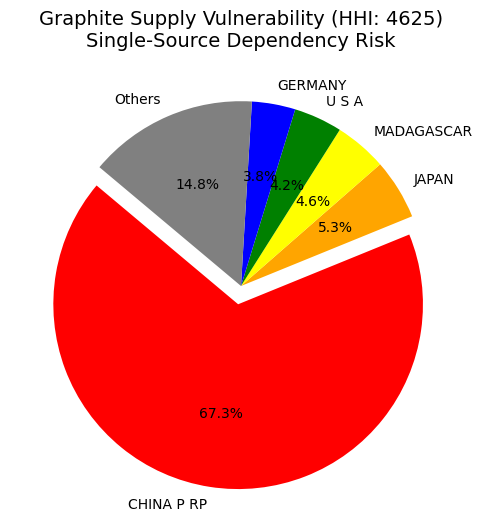

In [ ]:
# ==========================================
# 3. Visualization: The "China Dependency" Pie
# ==========================================
plt.figure(figsize=(10, 6))

# Group small players into "Others"
top_5 = df_risk.head(5).copy()
others_val = df_risk.iloc[5:]['Total'].sum()
# Create a DataFrame for "Others" to concatenate
others_df = pd.DataFrame([{'Country/Region': 'Others', 'Total': others_val}])
# Concatenate using pd.concat
plot_data = pd.concat([top_5, others_df], ignore_index=True)

# Plot
plt.pie(plot_data['Total'], labels=plot_data['Country/Region'], autopct='%1.1f%%',
        startangle=140, colors=['red', 'orange', 'yellow', 'green', 'blue', 'grey'],
        explode=(0.1, 0, 0, 0, 0, 0)) # Explode the 1st slice (China)

plt.title(f'Graphite Supply Vulnerability (HHI: {hhi_score:.0f})\nSingle-Source Dependency Risk', fontsize=14)
plt.savefig('Graphite_Concentration_Risk.png')
plt.show() 

In [19]:
# ==========================================
# 4. Visualization: Net Trade Balance
# ==========================================
# Load Time Series
def load_ts(filename):
    df = pd.read_excel(filename)
    total = df[df['Country/Region'] == 'Total'].drop(columns=['Country/Region', 'Total'])
    long = total.melt(var_name='Date_Str', value_name='Value')
    long['Date'] = pd.to_datetime(long['Date_Str'], format='%b-%Y')
    return long.sort_values('Date').set_index('Date')['Value']

In [20]:
imp_ts = load_ts('Graphite import Forecsting.xlsx')
exp_ts = load_ts('Graphite export Forecasting.xlsx')

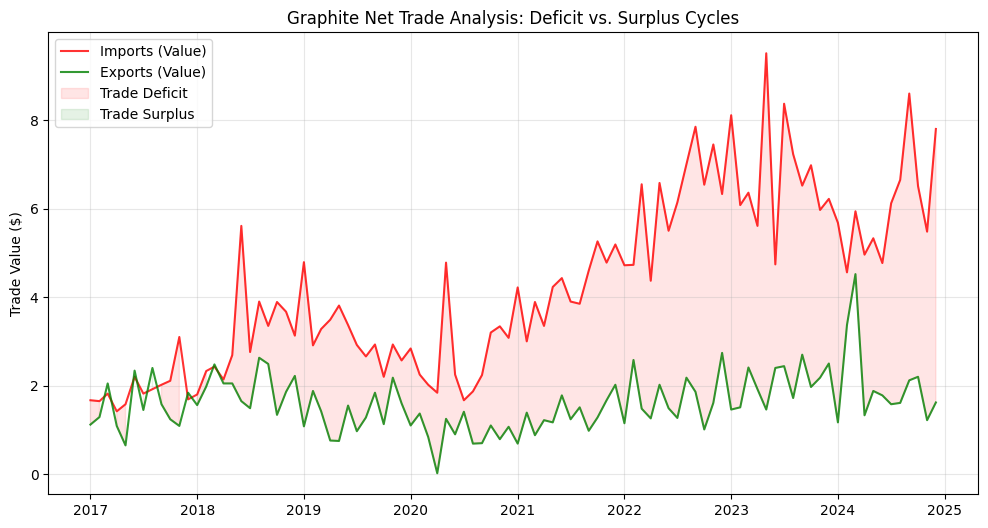

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(imp_ts.index, imp_ts, label='Imports (Value)', color='red', alpha=0.8)
plt.plot(exp_ts.index, exp_ts, label='Exports (Value)', color='green', alpha=0.8)

# Fill gaps
plt.fill_between(imp_ts.index, imp_ts, exp_ts, where=(imp_ts > exp_ts),
                 color='red', alpha=0.1, label='Trade Deficit')
plt.fill_between(imp_ts.index, imp_ts, exp_ts, where=(imp_ts < exp_ts),
                 color='green', alpha=0.1, label='Trade Surplus')

plt.title('Graphite Net Trade Analysis: Deficit vs. Surplus Cycles')
plt.ylabel('Trade Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('Graphite_Net_Trade.png')
plt.show()